In [631]:
pip install micromlgen

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [632]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
import seaborn as sns
import scipy
from micromlgen import port
from scipy import stats
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import median_absolute_deviation
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from scipy.signal import find_peaks
from sklearn.feature_selection import RFE

In [633]:
SAMPLES_PER_GESTURE = 450 # number of samples per gesture

#Load data from test_data.csv file
df = pd.read_csv("/content/" + 'MegaDataset.csv')

#removing participant ID and time for now
df= df.drop('Participant ID', axis=1)
df= df.drop('Time', axis=1)

In [634]:
#split data based on activity labels
df7 = df[df['Label'] == 'Descending stairs']

df7.to_csv('Descending stairs.csv')
df6 = df[df['Label'] == 'Ascending stairs']

df6.to_csv('Ascending stairs.csv')
df5 = df[df['Label'] == 'Dancing']

df5.to_csv('Dancing.csv')
df4 = df[df['Label'] == 'Running']

df4.to_csv('Running.csv')
df3 = df[df['Label'] == 'Standing']

df3.to_csv('Standing.csv')
df2 = df[df['Label'] == 'Walking']

df2.to_csv('Walking.csv')
df1 = df[df['Label'] == 'Sitting/Working with a computer']

df1.to_csv('Sitting.csv')
df0 = df[df['Label'] == 'Jumping']

df0.to_csv('Jumping.csv')

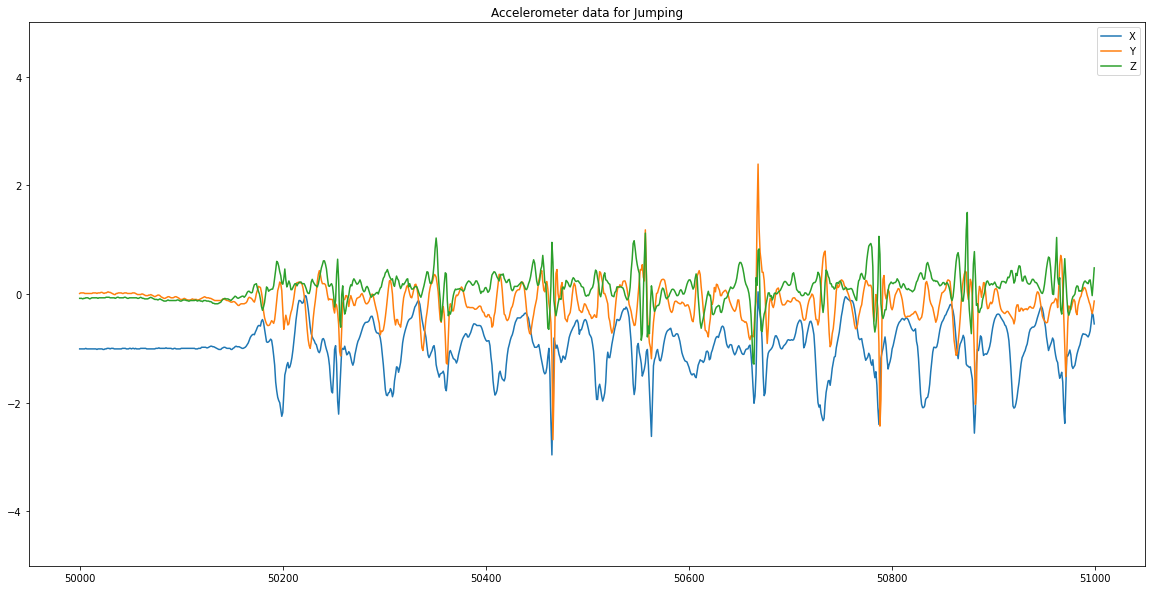

(100000, 7)


In [635]:
current_activity = df7
plt.figure(figsize=(20, 10))
plt.ylim(-5, 5)
plt.plot(current_activity.iloc[:1000, 0], label='X')
plt.plot(current_activity.iloc[:1000, 1], label='Y')
plt.plot(current_activity.iloc[:1000, 2], label='Z')
plt.title('Accelerometer data for Jumping')
plt.legend()
plt.show()
print(current_activity.shape)

In [636]:
# segment data into windows of 1000 samples
def segment_signal(data, window_size, overlap=0):
    # data is a 2D array
    # window_size is the number of samples in each window
    # overlap is the percentage of overlap between windows
    # Number of samples in each window
    N = data.shape[0]
    # Number of dimensions (3 for accelerometer and 3 for gyroscope)
    D = data.shape[1]
    # Number of samples in each window
    step = int(window_size * (1 - overlap))
    # Number of windows
    num_windows = int(np.ceil((N - window_size) / step))
    # Initialize output array
    segments = np.empty((num_windows, window_size, D))
    # Create windows
    for i in range(num_windows):
        start = i * step
        end = start + window_size
        segments[i, :, :] = data[start:end, :]
    return segments

In [637]:
# Segment data into windows of SAMPLES_PER_GESTURE samples
X7 = segment_signal(df7.iloc[:, :-1].values, SAMPLES_PER_GESTURE)
X6 = segment_signal(df6.iloc[:, :-1].values, SAMPLES_PER_GESTURE)
X5 = segment_signal(df5.iloc[:, :-1].values, SAMPLES_PER_GESTURE)
X4 = segment_signal(df4.iloc[:, :-1].values, SAMPLES_PER_GESTURE)
X3 = segment_signal(df3.iloc[:, :-1].values, SAMPLES_PER_GESTURE)
X2 = segment_signal(df2.iloc[:, :-1].values, SAMPLES_PER_GESTURE)
X1 = segment_signal(df1.iloc[:, :-1].values, SAMPLES_PER_GESTURE)
X0 = segment_signal(df0.iloc[:, :-1].values, SAMPLES_PER_GESTURE)

#label the segments based on the activity label of the first sample in each window 
y7 = np.full(X7.shape[0], 7)
y6 = np.full(X6.shape[0], 6)
y5 = np.full(X5.shape[0], 5)
y4 = np.full(X4.shape[0], 4)
y3 = np.full(X3.shape[0], 3)
y2 = np.full(X2.shape[0], 2)
y1 = np.full(X1.shape[0], 1)
y0 = np.full(X0.shape[0], 0)

# combine data from activities
X = np.concatenate((X7, X6, X5, X4, X3, X2, X1, X0), axis=0)
y = np.concatenate((y7, y6, y5, y4, y3, y2, y1, y0), axis=0)
X0.shape

(259, 450, 6)

In [638]:
def extract_features(X):
    # X is a 3D array
    # Number of windows
    N = X.shape[0]
    # Number of samples in each window
    M = X.shape[1]
    # Number of dimensions (3 for accelerometer and 3 for gyroscope)
    D = X.shape[2]
    # Initialize output array
    features = np.empty((N, 6 * D))
    # Loop over windows
    for i in range(N):
        # Loop over dimensions
        for j in range(D):
            # Calculate statistical features
            x = X[i, :, j]
            features[i, 6 * j] = np.mean(x)
            features[i, 6 * j + 1] = np.std(x)
            features[i, 6 * j + 2] = np.median(x)
            #features[i, 6 * j + 3] = np.min(x)
            #features[i, 6 * j + 4] = np.max(x)
            features[i, 6 * j + 5] = skew(x)
            # features[i, 8 * j + 6] = kurtosis(x)
            # features[i, 8 * j + 7] = np.median(np.absolute(x - np.median(x)))
            # features[i, 13 * j + 8] = np.sum(x < 0)
            # features[i, 13 * j + 9] = np.sum(x > 0)
            # features[i, 13 * j + 10] = np.sum(x > x.mean())
            # features[i, 13 * j + 11] = len(find_peaks(x)[0])
            # features[i, 13 * j + 12] = np.sum(x**2)/200
    return features

In [639]:
# Extract features from each window
X_features = extract_features(X)
# Getting the shape of the extracted data
X_features.shape

(2090, 36)

In [640]:
# rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=5, step=1)
# fit = rfe.fit(X_train, y_train)
# X_train = rfe.transform(X_train)
# print('Selected Features: %s' % fit.support_)
# print('Feature Ranking: %s' % fit.ranking_)
# X_train.shape

In [641]:
#Selecting the selected features for the test set for future classification, the above feature selection method selected features 0,1,6,19, and 31
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.25, random_state=42, stratify=y)
test_dataset_features = X_test[:, [0,1,6,19,31]]
#print(new_dataset)
print(test_dataset_features.shape)

(523, 5)


In [642]:
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.33, random_state=42, stratify=y)

In [643]:
# define models
models = []
models.append(('DT', DecisionTreeClassifier(random_state=0, max_depth=2)))
#models.append(('MLP', MLPClassifier(solver='lbfgs', alpha=0.1, hidden_layer_sizes=(20,), random_state=0)))
models.append(('RF', RandomForestClassifier()))
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
models.append(('ET', ExtraTreesClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVM', SVC()))
models.append(('SGD', SGDClassifier()))

In [644]:
# train and test model performance without cross validation
results = []
names = []
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results.append(accuracy_score(y_test, y_pred))
    names.append(name)
    msg = "%s: %f" % (name, accuracy_score(y_test, y_pred))
    print(msg)
test_dataset_features.shape

DT: 0.400000
RF: 0.927536
AB: 0.444928
GBM: 0.921739
ET: 0.940580
KNN: 0.644928
SVM: 0.481159
SGD: 0.427536


(523, 5)

In [645]:
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(name)
    print(confusion_matrix(y_test, y_pred))


DT
[[ 0  1 82  3  0  0  0  0]
 [ 0 60 14 11  0  0  0  0]
 [ 0  9 93  0  0  0  0  4]
 [ 0 26 11 52  0  0  0  0]
 [ 0  0 91  0  0  0  0  0]
 [ 0  1 84  0  0  0  0  0]
 [ 0  3 34  4  0  0  0 34]
 [ 0  0  0  2  0  0  0 71]]
RF
[[ 85   0   0   1   0   0   0   0]
 [  1  75   7   1   1   0   0   0]
 [  0   1 103   2   0   0   0   0]
 [  0   3   6  77   2   1   0   0]
 [  0   0   5   0  85   1   0   0]
 [  0   0   2   0   1  81   1   0]
 [  0   2   2   5   0   7  59   0]
 [  0   0   0   0   0   0   0  73]]
AB
[[ 0  4 82  0  0  0  0  0]
 [ 0 25 10 46  3  1  0  0]
 [ 0  4 29  5 34 33  0  1]
 [ 0 27  2 51  6  3  0  0]
 [ 0  0 23  0 58 10  0  0]
 [ 0  0  7  1  4 73  0  0]
 [ 0  0  0  7  0 34  0 34]
 [ 0  0  0  0  0  0  2 71]]
GBM
[[ 84   2   0   0   0   0   0   0]
 [  1  71   6   5   2   0   0   0]
 [  0   1 100   4   0   0   1   0]
 [  0   1   7  80   1   0   0   0]
 [  0   1   5   0  83   2   0   0]
 [  0   0   1   0   0  82   2   0]
 [  0   1   0   4   0   6  64   0]
 [  0   0   0   0   0   0  

In [646]:
 for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(name)
    print(classification_report(y_test, y_pred))

DT
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        86
           1       0.60      0.71      0.65        85
           2       0.23      0.88      0.36       106
           3       0.72      0.58      0.65        89
           4       0.00      0.00      0.00        91
           5       0.00      0.00      0.00        85
           6       0.00      0.00      0.00        75
           7       0.65      0.97      0.78        73

    accuracy                           0.40       690
   macro avg       0.28      0.39      0.30       690
weighted avg       0.27      0.40      0.30       690



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RF
              precision    recall  f1-score   support

           0       0.99      0.98      0.98        86
           1       0.93      0.89      0.91        85
           2       0.82      0.96      0.89       106
           3       0.87      0.87      0.87        89
           4       0.96      0.93      0.94        91
           5       0.94      0.94      0.94        85
           6       0.98      0.83      0.90        75
           7       1.00      1.00      1.00        73

    accuracy                           0.93       690
   macro avg       0.94      0.93      0.93       690
weighted avg       0.93      0.93      0.93       690

AB
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        86
           1       0.42      0.29      0.34        85
           2       0.19      0.27      0.22       106
           3       0.46      0.57      0.51        89
           4       0.55      0.64      0.59        91
           5      

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GBM
              precision    recall  f1-score   support

           0       0.99      0.98      0.98        86
           1       0.92      0.84      0.88        85
           2       0.84      0.94      0.89       106
           3       0.86      0.90      0.88        89
           4       0.97      0.91      0.94        91
           5       0.91      0.96      0.94        85
           6       0.96      0.85      0.90        75
           7       1.00      1.00      1.00        73

    accuracy                           0.92       690
   macro avg       0.93      0.92      0.93       690
weighted avg       0.93      0.92      0.92       690

ET
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        86
           1       0.94      0.87      0.90        85
           2       0.86      0.94      0.90       106
           3       0.86      0.88      0.87        89
           4       0.94      0.93      0.94        91
           5     

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [647]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
print(port(clf))

#pragma once
#include <cstdarg>
namespace Eloquent {
    namespace ML {
        namespace Port {
            class DecisionTree {
                public:
                    /**
                    * Predict class for features vector
                    */
                    int predict(float *x) {
                        if (x[31] <= 6.233536720275879) {
                            if (x[2] <= -0.9449999928474426) {
                                if (x[0] <= -1.013200044631958) {
                                    return 1;
                                }

                                else {
                                    if (x[8] <= 0.23499999940395355) {
                                        return 3;
                                    }

                                    else {
                                        if (x[4] <= -0.6099999845027924) {
                                            return 7;
                                        }

                 

In [648]:
# sklearn .mdel_selection import RepeatedStratifiedKFoId
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from statistics import mean
import numpy as np
# define the evaluation method
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# evaluate the model
for model in models:
  scores = cross_validate(model[1],X_features, y, scoring=('accuracy', 'precision_macro', 'recall_macro', 'f1_macro'), cv=cv, n_jobs=-1, error_score='raise')
  # report performance
  print(model)
  print('Accuracy: %.3f (%.3f)' % (mean(scores['test_accuracy']), np.std(scores['test_accuracy'])))
  print('Precision: %.3f (%.3f)' % (mean(scores['test_precision_macro']), np.std(scores['test_precision_macro'])))
  print('Reca11: %.3f (%.3f)' % (mean(scores['test_recall_macro']), np.std(scores['test_recall_macro'])))
  print('F-1 Score: %.3f (%.3f)' % (mean(scores['test_f1_macro']), np.std(scores['test_f1_macro'])))

('DT', DecisionTreeClassifier(max_depth=2, random_state=0))
Accuracy: 0.407 (0.015)
Precision: 0.281 (0.013)
Reca11: 0.399 (0.015)
F-1 Score: 0.307 (0.013)


KeyboardInterrupt: ignored

In [649]:
import re
_code = port(clf)
round_to_digits = 3
_code_quantized = re.sub(r'(\d+\.\d+)', lambda m: str(round(float(m.group(1)), round_to_digits)), _code)
print(_code_quantized)
fs = open("/content/dttest.h","w")
fs.write(_code_quantized)
fs.close()

#pragma once
#include <cstdarg>
namespace Eloquent {
    namespace ML {
        namespace Port {
            class DecisionTree {
                public:
                    /**
                    * Predict class for features vector
                    */
                    int predict(float *x) {
                        if (x[31] <= 6.234) {
                            if (x[2] <= -0.945) {
                                if (x[0] <= -1.013) {
                                    return 1;
                                }

                                else {
                                    if (x[8] <= 0.235) {
                                        return 3;
                                    }

                                    else {
                                        if (x[4] <= -0.61) {
                                            return 7;
                                        }

                                        else {
                                   

## LOSO (Leave-One-Subject-Out) Experiment

We have 12 participants in the dataset! So we start by preparing the data for 11 participants to get it ready for training, while also get the test data ready for the participant that we left out!
I left p5 data out in this example, and train my models on other 11 participants! I test the trained model on p5 at the end.

In [ ]:
df = pd.read_csv("/content/" +'MegaDataset.csv')
#split the data for leave one Participant out cross validation for all 10 participants 
df11 = df[df['Participant ID'] == 'p10']
df10 = df[df['Participant ID'] == 'p19']
df9 = df[df['Participant ID'] == 'p20']
df8 = df[df['Participant ID'] == 'p1']
df7 = df[df['Participant ID'] == 'p2']
df6 = df[df['Participant ID'] == 'p3']
df5 = df[df['Participant ID'] == 'p7']
df4 = df[df['Participant ID'] == 'p6']
df3 = df[df['Participant ID'] == 'p4']
df2 = df[df['Participant ID'] == 'p8']
df1 = df[df['Participant ID'] == 'p9']
df0 = df[df['Participant ID'] == 'p5'] # we leave this participant out in this iteration!

# prepare data for training on all participants except one 
df_train = pd.concat([df11,df10, df9, df8, df7, df6, df5, df4, df3, df2, df1], ignore_index=True)
df_test = df0 #participant p9

df_train= df_train.drop('Participant ID', axis=1) 
df_train= df_train.drop('Time', axis=1)

df_test= df_test.drop('Participant ID', axis=1) 
df_test= df_test.drop('Time', axis=1)

print(df_train.shape)
print(df_test.shape)

In [ ]:
#split data based on activity labels for training set
df7_loso = df_train[df_train['Label'] == 'Descending stairs']
df6_loso = df_train[df_train['Label'] == 'Ascending stairs']
df5_loso = df_train[df_train['Label'] == 'Dancing']
df4_loso = df_train[df_train['Label'] == 'Running']
df3_loso = df_train[df_train['Label'] == 'Standing']
df2_loso = df_train[df_train['Label'] == 'Walking']
df1_loso = df_train[df_train['Label'] == 'Sitting/Working with a computer']
df0_loso = df_train[df_train['Label'] == 'Jumping']

#split data based on activity labels for the left participant
df7_loso_test = df_test[df_test['Label'] == 'Descending stairs']
df6_loso_test = df_test[df_test['Label'] == 'Ascending stairs']
df5_loso_test = df_test[df_test['Label'] == 'Dancing']
df4_loso_test = df_test[df_test['Label'] == 'Running']
df3_loso_test = df_test[df_test['Label'] == 'Standing']
df2_loso_test = df_test[df_test['Label'] == 'Walking']
df1_loso_test = df_test[df_test['Label'] == 'Sitting/Working with a computer']
df0_loso_test = df_test[df_test['Label'] == 'Jumping']


In [ ]:
# Segment data into windows of 500 samples and 0% overlap (0 samples)
X7 = segment_signal(df7_loso.iloc[:, :-1].values, SAMPLES_PER_GESTURE)
X6 = segment_signal(df6_loso.iloc[:, :-1].values, SAMPLES_PER_GESTURE)
X5 = segment_signal(df5_loso.iloc[:, :-1].values, SAMPLES_PER_GESTURE)
X4 = segment_signal(df4_loso.iloc[:, :-1].values, SAMPLES_PER_GESTURE)
X3 = segment_signal(df3_loso.iloc[:, :-1].values, SAMPLES_PER_GESTURE)
X2 = segment_signal(df2_loso.iloc[:, :-1].values, SAMPLES_PER_GESTURE)
X1 = segment_signal(df1_loso.iloc[:, :-1].values, SAMPLES_PER_GESTURE)
X0 = segment_signal(df0_loso.iloc[:, :-1].values, SAMPLES_PER_GESTURE)


X7_test = segment_signal(df7_loso_test.iloc[:, :-1].values, SAMPLES_PER_GESTURE)
X6_test = segment_signal(df6_loso_test.iloc[:, :-1].values, SAMPLES_PER_GESTURE)
X5_test = segment_signal(df5_loso_test.iloc[:, :-1].values, SAMPLES_PER_GESTURE)
X4_test = segment_signal(df4_loso_test.iloc[:, :-1].values, SAMPLES_PER_GESTURE)
X3_test = segment_signal(df3_loso_test.iloc[:, :-1].values, SAMPLES_PER_GESTURE)
X2_test = segment_signal(df2_loso_test.iloc[:, :-1].values, SAMPLES_PER_GESTURE)
X1_test = segment_signal(df1_loso_test.iloc[:, :-1].values, SAMPLES_PER_GESTURE)
X0_test = segment_signal(df0_loso_test.iloc[:, :-1].values, SAMPLES_PER_GESTURE)


#label the segments based on the activity label of the first sample in each window

y7 = np.full(X7.shape[0], 7)
y6 = np.full(X6.shape[0], 6)
y5 = np.full(X5.shape[0], 5)
y4 = np.full(X4.shape[0], 4)
y3 = np.full(X3.shape[0], 3)
y2 = np.full(X2.shape[0], 2)
y1 = np.full(X1.shape[0], 1)
y0 = np.full(X0.shape[0], 0)

y7_test = np.full(X7_test.shape[0], 7)
y6_test = np.full(X6_test.shape[0], 6)
y5_test = np.full(X5_test.shape[0], 5)
y4_test = np.full(X4_test.shape[0], 4)
y3_test = np.full(X3_test.shape[0], 3)
y2_test = np.full(X2_test.shape[0], 2)
y1_test = np.full(X1_test.shape[0], 1)
y0_test = np.full(X0_test.shape[0], 0)


In [ ]:
X_loso = np.concatenate((X7, X6, X5, X4, X3, X2, X1, X0), axis=0)
y_loso = np.concatenate((y7, y6, y5, y4, y3, y2, y1, y0), axis=0)
print(X_loso.shape)

X_loso_test = np.concatenate((X7_test, X6_test, X5_test, X4_test, X3_test, X2_test, X1_test, X0_test), axis=0)
y_loso_test = np.concatenate((y7_test, y6_test, y5_test, y4_test, y3_test, y2_test, y1_test, y0_test), axis=0)
print(X_loso_test.shape)

In [ ]:
X_features_loso = extract_features(X_loso)
print(X_features_loso.shape)

X_features_loso_test = extract_features(X_loso_test)
print(X_features_loso_test.shape)

In [ ]:
# train and test model performance without cross validation
results = []
names = []
for name, model in models:
    model.fit(X_features_loso, y_loso)
    y_pred = model.predict(X_features_loso_test)
    results.append(accuracy_score(y_loso_test, y_pred))
    names.append(name)
    msg = "%s: %f" % (name, accuracy_score(y_loso_test, y_pred))
    print(msg)